In [1]:
import pandas as pd
import numpy as np

from numpy import random as rd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from ito_diffusion_multi_d import *
from lasso import *

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.style.use('dark_background')

In [2]:
params = {
    'font.size': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.figsize': (11,7),
}
plt.rcParams.update(params)

In [3]:
m, n = 300, 3
T = 1
n_epochs = int(1e3)
learning_rate = 0.01

## Generate synthetic data : 3 correlated Brownian motions

In [4]:
def generate_data(rhos=[0, 0, 0],
                  sigmas=[1, 1, 1],
                  drift=[0, 0, 0],
                 standardize=True):
    """Generate synthetic price series from Brownian sampling.
    """
    x0 = [100, ] * n
    keys = ['x_{}'.format(i+1) for i in range(n)]
    X = BM_multi_d(x0=x0, 
                   T=T, 
                   drift=drift, 
                   vol=np.eye(n), 
                   scheme_steps=m, 
                   keys=keys)

    rho_12, rho_13, rho_23 = rhos
    sigma_1, sigma_2, sigma_3 = sigmas

    cov_12, cov_23, cov_13 = rho_12*sigma_1*sigma_2, rho_23*sigma_2*sigma_3, rho_13*sigma_1*sigma_3
    vol = [[sigma_1**2, cov_12, cov_13],[cov_12, sigma_2**2, cov_23], [cov_13, cov_23, sigma_3**2]]    

    X.vol_matrix = vol
    df = X.simulate()

    # returns
    rets = ((df-df.shift(1))/df.shift(1)).iloc[1:]

    # individual returns
    data = np.array(rets)
    # returns of a equiweighhted portfolio
    target = np.array(rets).sum(axis=1).reshape(-1, 1) / n 

    if standardize:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
        target = scaler.fit_transform(target)
    
    return data, target, df, rets

In [5]:
def plot_data(ts, rhos):
    fig, axes = plt.subplots(figsize=(21, 7), nrows=1, ncols=2)

    plt.suptitle('rho_12={:.0%}'.format(rhos[0])\
                 +', rho_13={:.0%}'.format(rhos[1])\
                 +', rho_23={:.0%}'.format(rhos[2]))

    ax = axes[0]
    ts.plot(kind='line', ax=ax)
    ax.legend(loc='lower left')

    rets = ((ts-ts.shift(1))/ts.shift(1)).iloc[1:]    

    ax = axes[1]
    rets.plot(kind='line', ax=ax)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
    ax.legend(loc='lower left')

## Train wrapper

In [6]:
def train(data, target, l1_strength=0.0):
    model = Lasso()
    model.X = data
    model.y = target
    model.n_epochs = n_epochs
    model.verbose = False
    model.l1_strength = l1_strength
    model.optim_params = {
        'optimizer_name': 'adam',
        'learning_rate': learning_rate,
    }
    model.fit()
    
    # Visualize the replication portfolio weights
    model.bar_plot()
    
    # scatter regression
    fig, axes = plt.subplots(figsize=(11,14), nrows=n, ncols=1)
    for i, ax in enumerate(axes):
        ax.scatter(data[:, i], target[:], marker='.', color='r', label='portfolio')
        ax.plot(data[:, i], np.matmul(data, model.theta), '.w', label='replication')
        ax.set_xlabel('Normalized x_{} returns'.format(i+1))
        ax.set_ylabel('Normalized portfolio returns')
        ax.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()

    # plot lasso path and number of active signals
    path, active_features_path, grid = model.lasso_path(n_l1_strength=20,
                                                        plot_path=True,
                                                        plot_active_features_path=True, 
                                                        threshold=1e-1)
    return model.theta

## Independant Brownian motions

In [7]:
drift = rd.normal(0, 1, n)
rhos = [0, 0, 0]
sigmas = [1, 1, 1]
data, target, df, rets = generate_data(rhos, sigmas, drift, standardize=True)

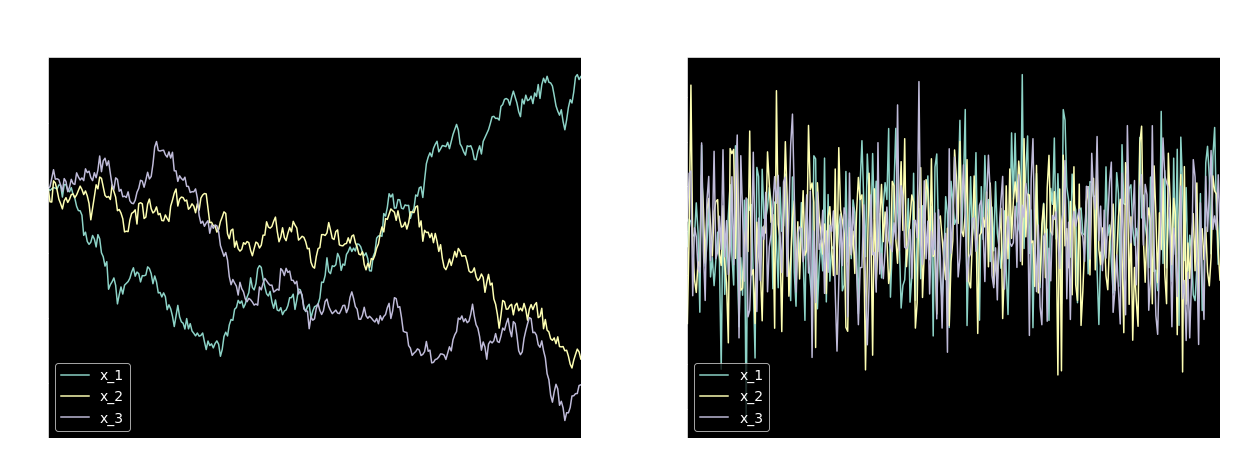

In [8]:
plot_data(df, rhos)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



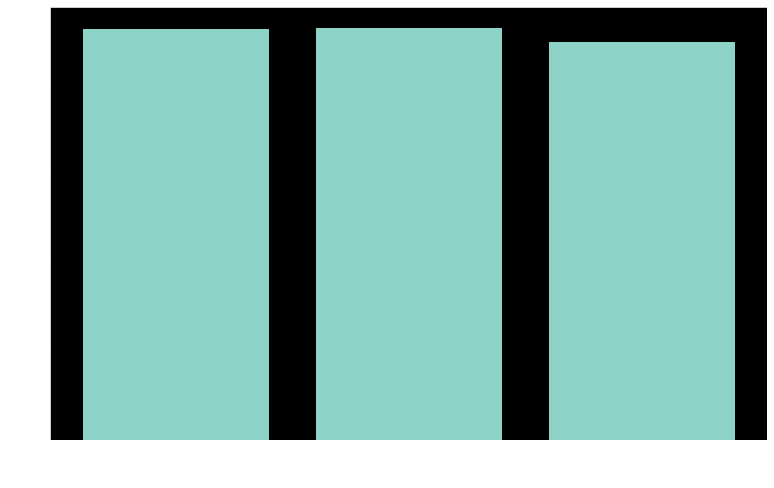

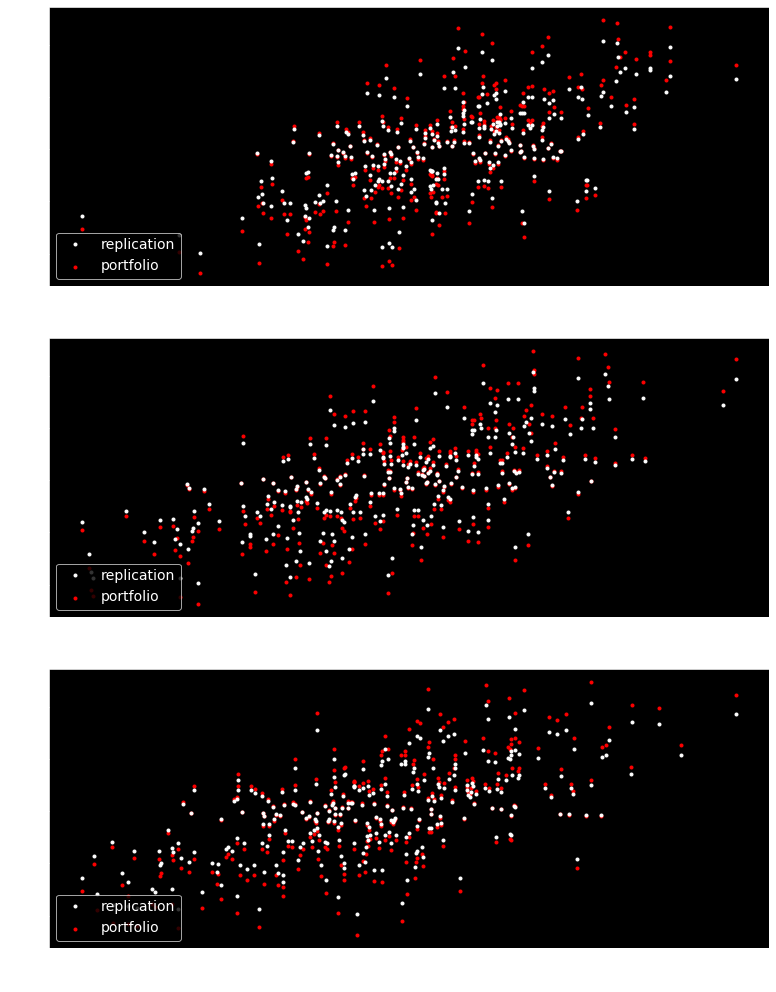

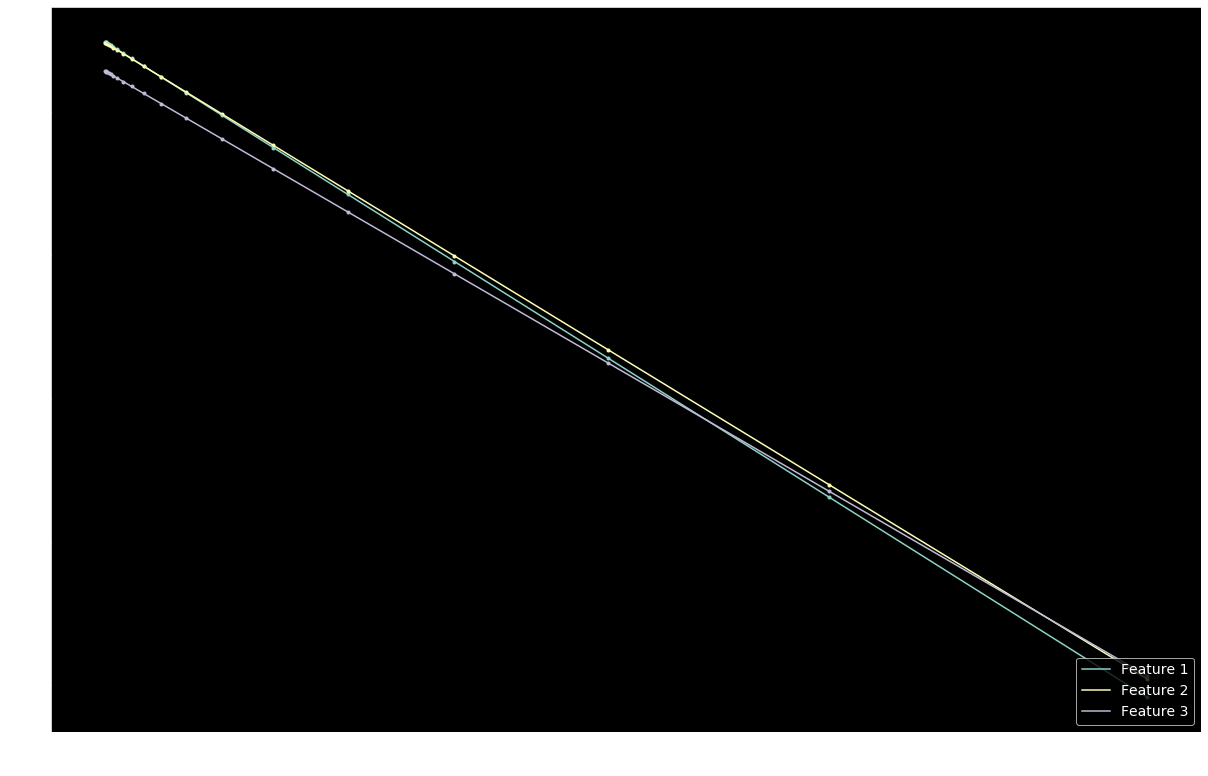

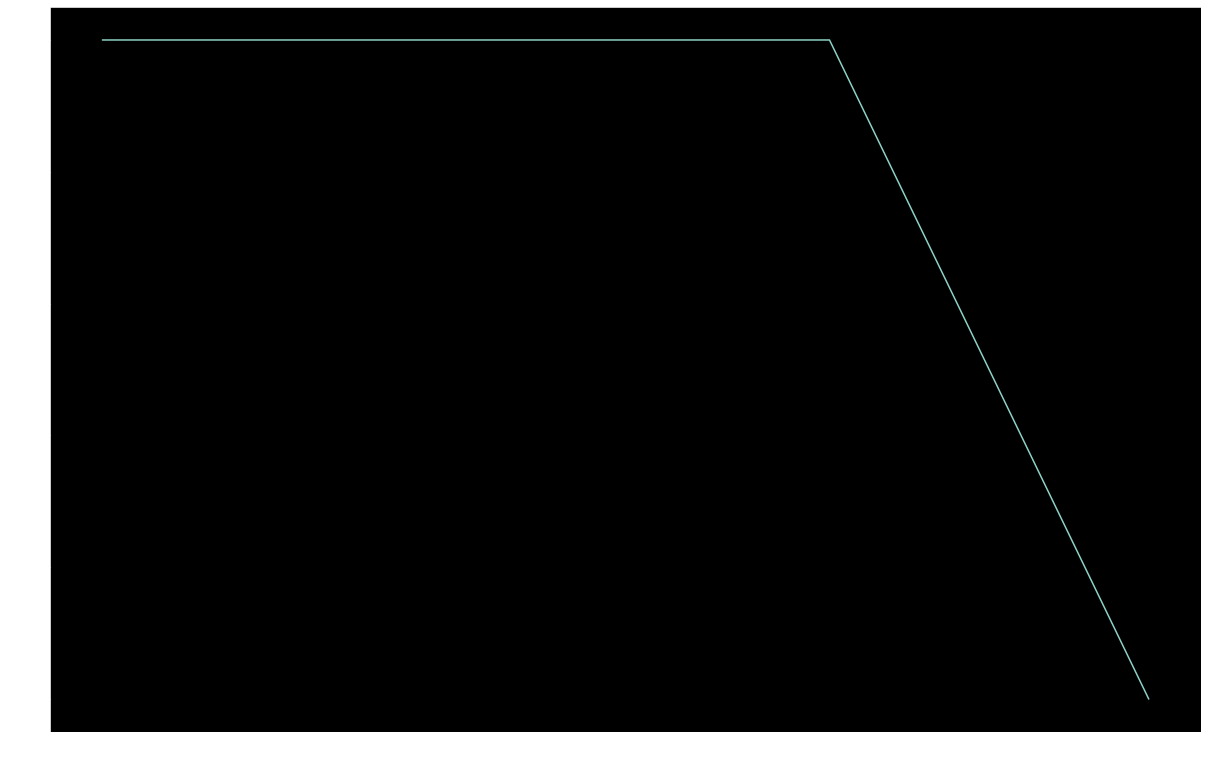

In [9]:
theta = train(data, target, l1_strength=0.2)

## Brownian motion with arbitrary correlations

Lasso learns to exploit correlations and select only one or two components to replicate the index

In [10]:
rhos = rd.uniform(-1, 1, n)
sigmas = rd.uniform(1, 5, n)
drift = rd.normal(0, 1, n)
data, target, df, rets = generate_data(rhos, sigmas, drift, standardize=True)

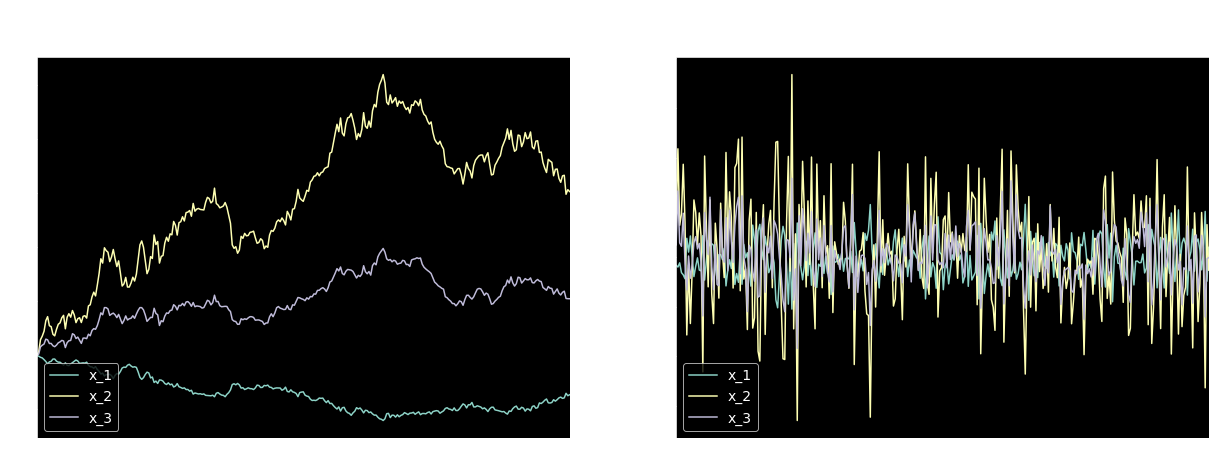

In [11]:
plot_data(df, rhos)

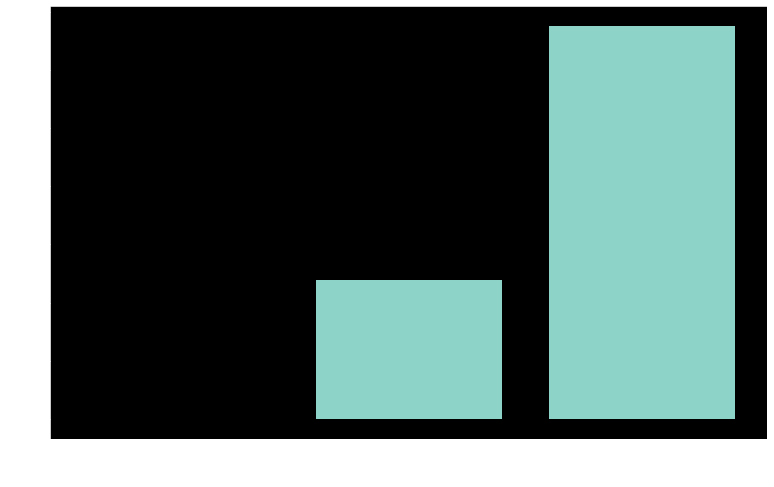

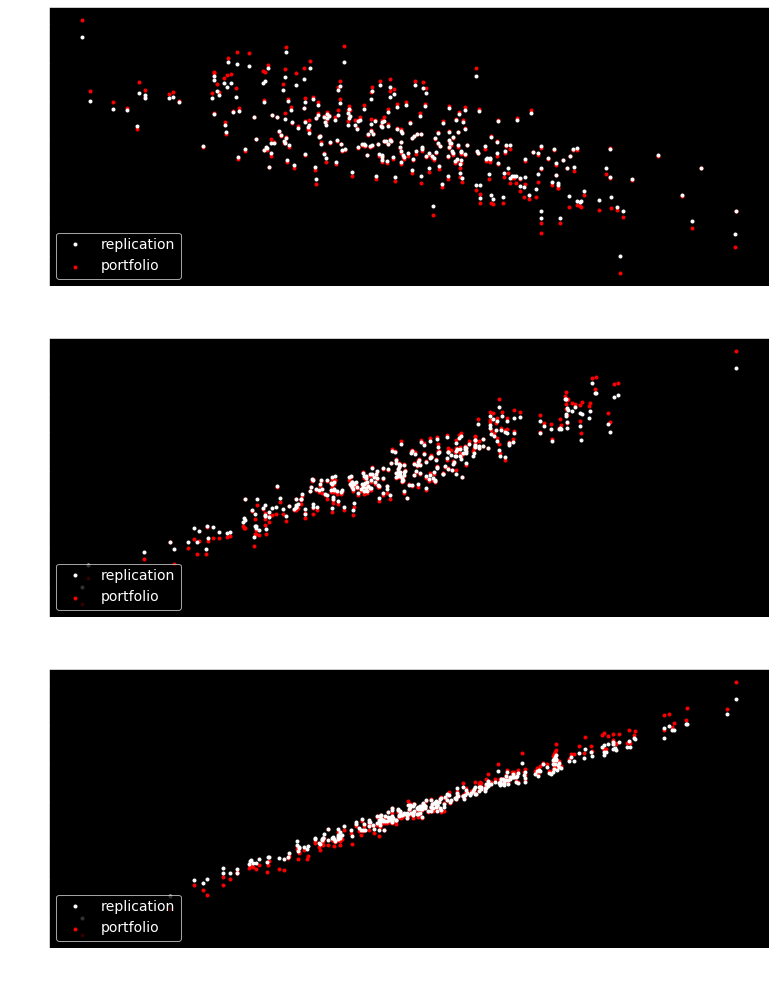

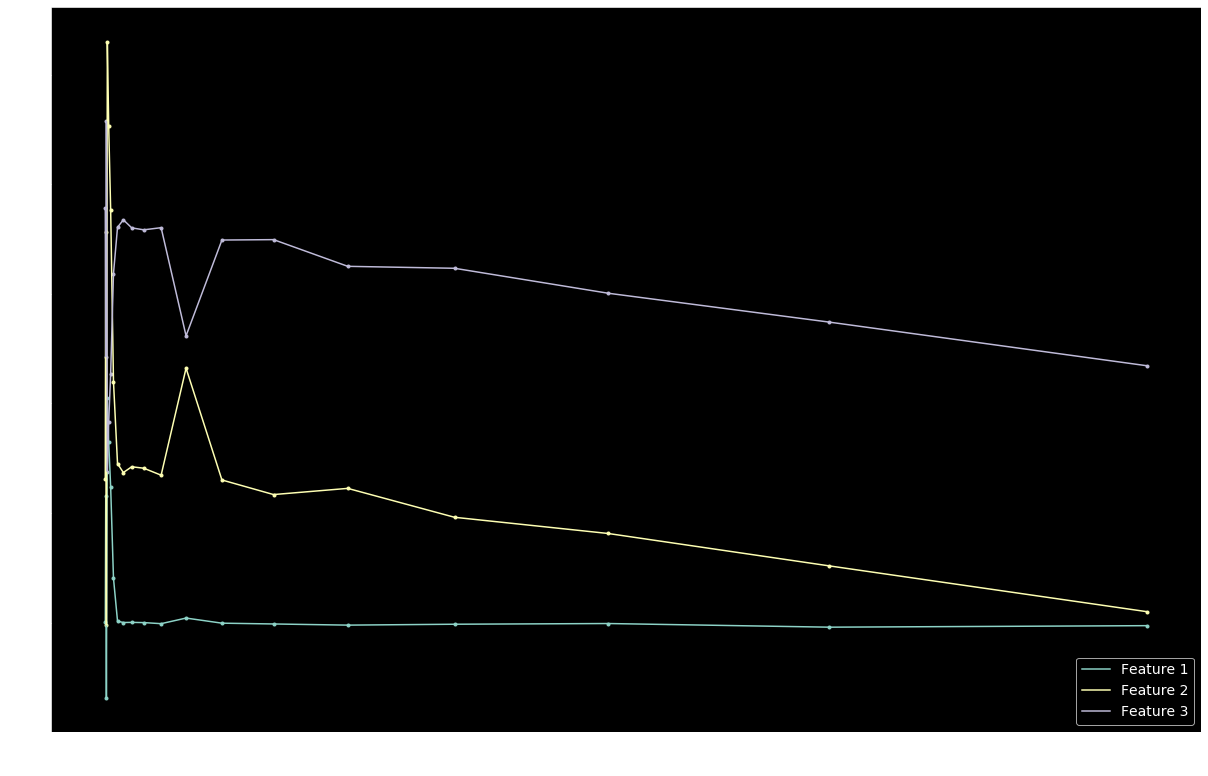

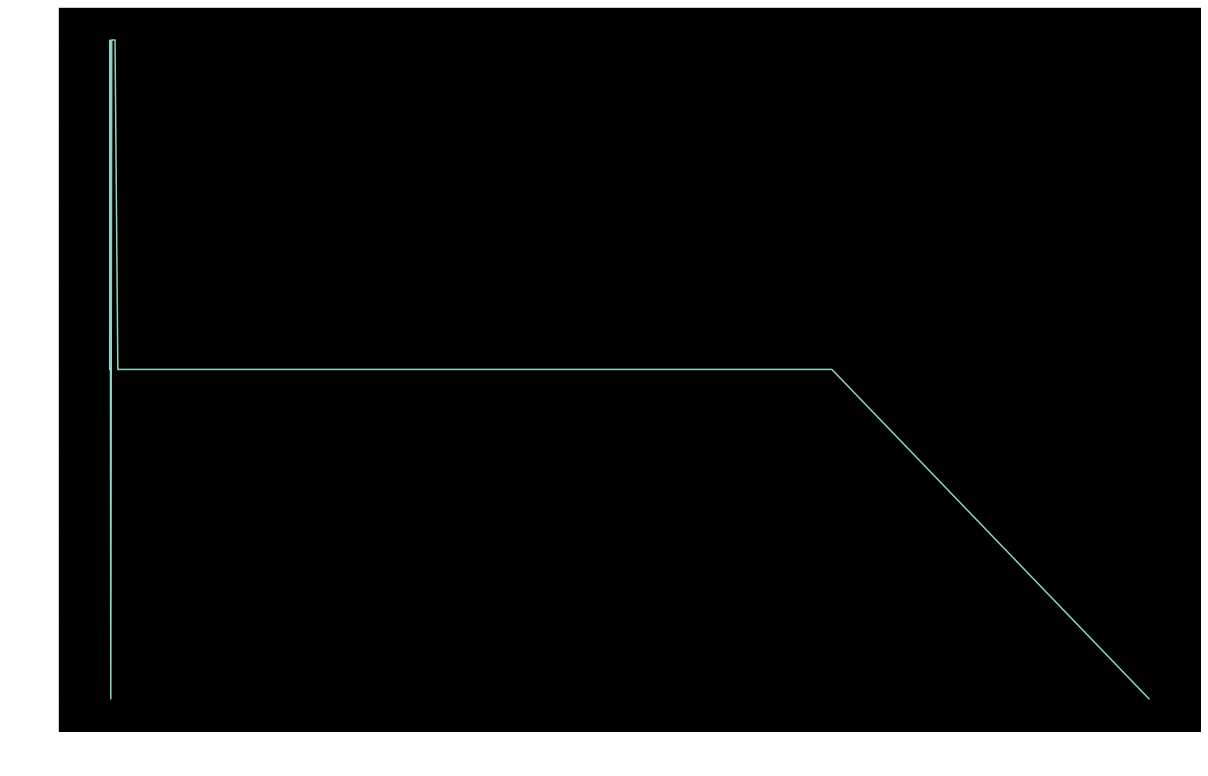

In [12]:
theta = train(data, target, l1_strength=0.2)